In [ ]:
# Taken and modfied code from https://gist.github.com/bigsnarfdude/d811e31ee17495f82f10db12651ae82d
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

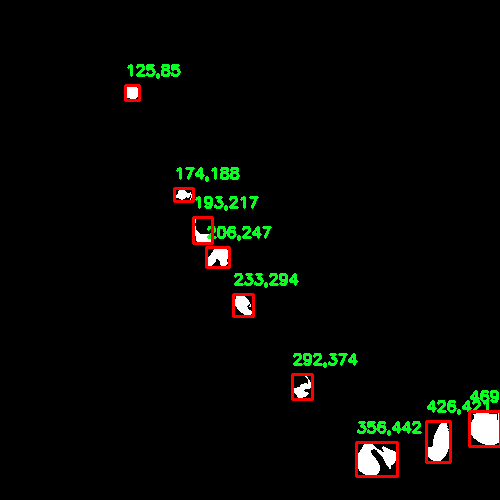

In [ ]:
path = 'Images/'
timestep = "01"
filename = path+'Ensemble1Timestep'+str(timestep)+'.png'
image = cv2.imread(filename, cv2.IMREAD_COLOR)
copy = image.copy()
gray = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

ROI_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    #cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    cv2.rectangle(copy,(x,y),(x+w,y+h),(0,0,255),2)
    cv2.putText(copy, str(x)+","+str(y), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    
    ROI_number += 1

cv2_imshow(copy)



In [ ]:
cap = cv2.VideoCapture("Images/Ensemble1Timestep%02d.png",cv2.CAP_IMAGES)
limit = 0
# time - index of contour - [centroid(x,y),contours]
eddy_features = []
while cap.isOpened() and limit < 10 :
    limit +=1 
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    features = []
    cnts = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1 )
    
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    
    for c in cnts:
      M = cv2.moments(c)
      #print(M['m00'])
      x,y,w,h = cv2.boundingRect(c)
      cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),1)
      
    
      
      if(M['m00'] != 0 ):
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        features.append([cx,cy,cv2.contourArea(c)])
        #print("contour area ",cv2.contourArea(c),(cx,cy))
      cv2.putText(frame, str(cx)+","+str(cy), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 2)
      # x,y,w,h = cv2.boundingRect(c)
      # print(c.shape)
      # ROI = image[y:y+h, x:x+w]
      # #cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
      # cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),1)
    
      # ROI_number += 1
    eddy_features.append(features)
    print(limit)
    cv2_imshow(frame)

    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

   
   #print(frame.shape)

NameError: ignored

In [ ]:
graph  = []
for centroid_list in eddy_features:
  l=[[] for i in range(len(centroid_list))]
  graph.append(l)
thresh = 15
 
for i in range(len(graph)):
  for j in range(len(graph[i])):
    if i+1 < len(graph):
      curr = np.array(eddy_features[i][j][0:2])
      curr_area = eddy_features[i][j][2]
      for  k in range(len(graph[i+1])):
        
        nxt = np.array(eddy_features[i+1][k][0:2])
        nxt_area = eddy_features[i+1][k][2]
        
        
        #print((i,j,k),matching_shape)
        if np.linalg.norm(curr-nxt) <= thresh and abs(nxt_area - curr_area) <= 200.0  :
          graph[i][j].append(k)


print(graph[0])
print("orig vert ",eddy_features[0][6])
for adj in graph[0][6] :
  print(eddy_features[1][adj])


NameError: ignored

In [ ]:
import networkx as nx
points_pos={}
nx_graph = nx.Graph()

for i in range(len(graph)):
  for j in range(len(graph[i])):
    nx_graph.add_node(f'({i},{j})')
    points_pos[f'({i},{j})']=  (i,j)

for i in range(len(graph)):
  for j in range(len(graph[i])):
    for adj in graph[i][j]:
      name1 = f"({i},{j})"
      name2 = f"({i+1},{adj})"
      nx_graph.add_edge(name1,name2)


import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
nx.draw(nx_graph, with_labels=True, pos=points_pos)
plt.set_xlabel("Timestep")
plt.show()

fig.savefig('eddy_life_cycle.png')

NameError: ignored

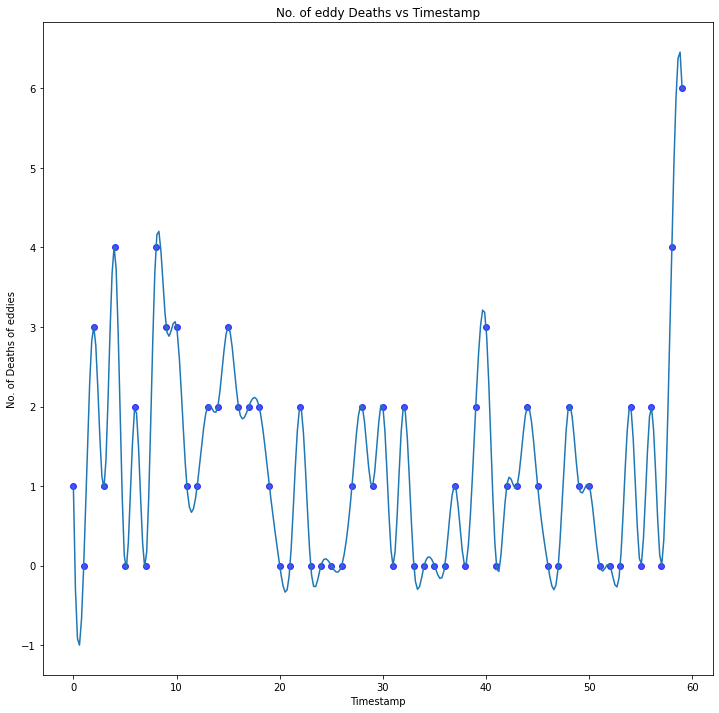

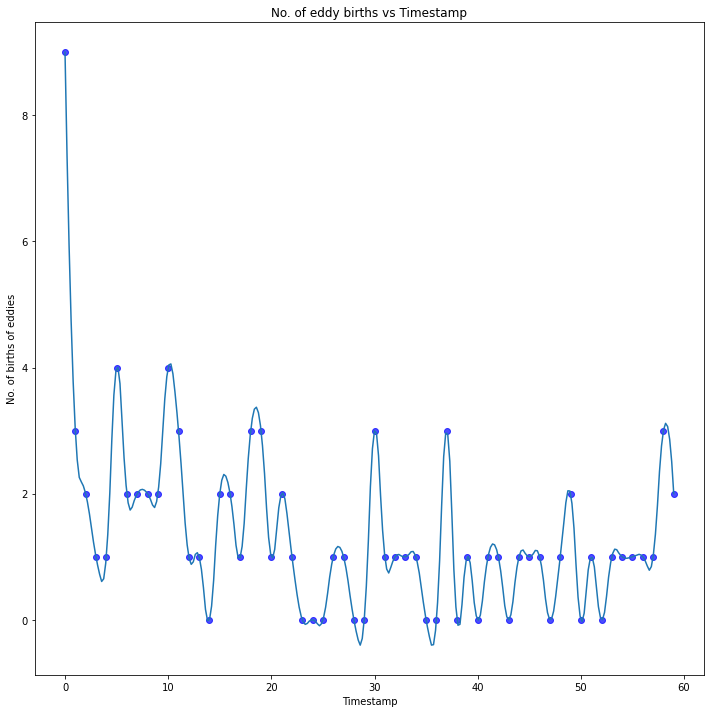

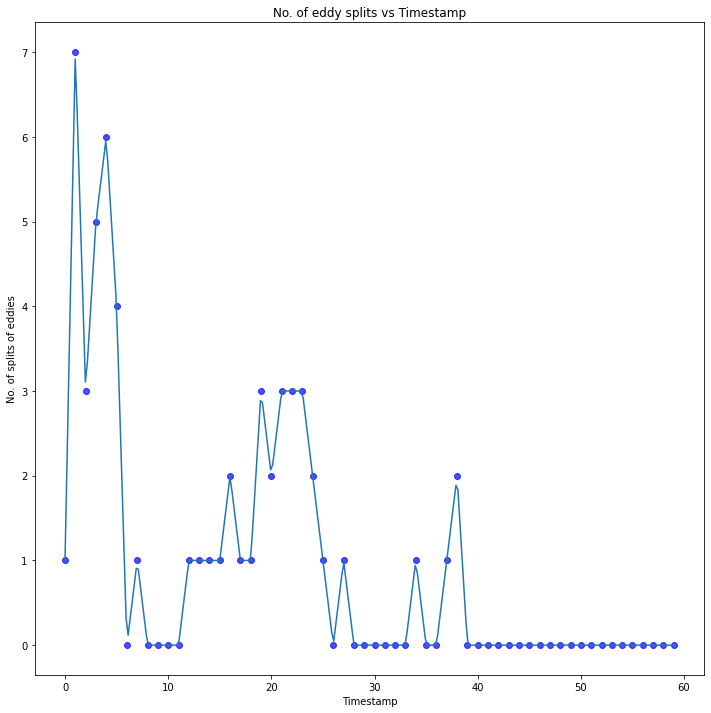

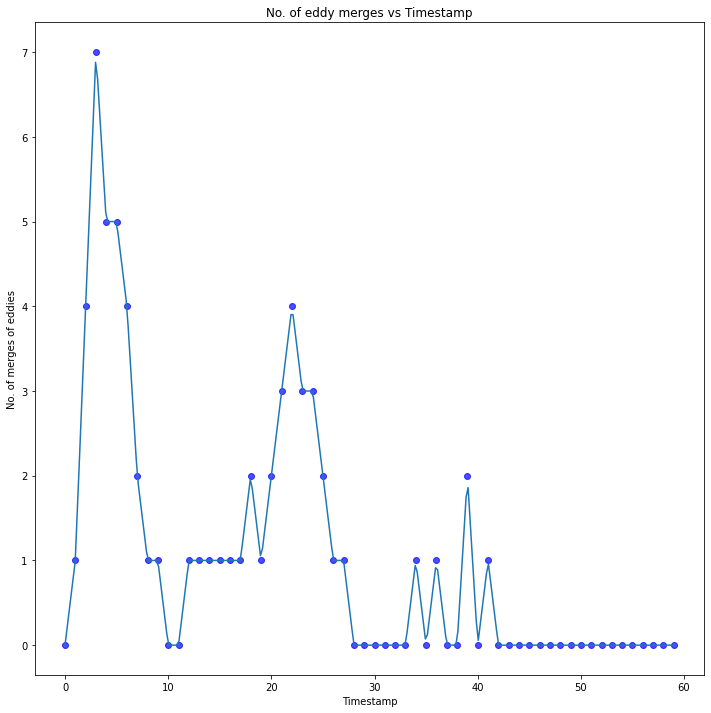

In [ ]:
#Life Span Distribution (# Eddies vs eddy life in days)
# Radii distribuition 

deaths = []
births =[]
splits=[]
# Eddy deaths
limiting_lvl = 2
is_dead =[]
is_born= []
is_splitted = []
merges = []
is_merged = []
merge_cnt = []


for i in range(len(graph)):
  is_born.append([])
  is_splitted.append([])
  is_merged.append([])
  merge_cnt.append([])
  for j in range(len(graph[i])):
    is_born[i].append(1)
    is_splitted[i].append(0)
    is_merged[i].append(0)
    merge_cnt[i].append(0)


for i in range(len(graph)):
  is_dead.append([])
  for j in range(len(graph[i])):
    is_dead[i].append(1)
    
    curr = np.array(eddy_features[i][j][0:2])
    curr_area = eddy_features[i][j][2]
    split_cnt = 0
    
    for lvl in range(1,limiting_lvl+1):
      if i+ lvl < len(graph):
        for k in range(len(graph[i+lvl])):
          nxt = np.array(eddy_features[i+lvl][k][0:2])
          nxt_area = eddy_features[i+lvl][k][2]
          if np.linalg.norm(curr-nxt) <= thresh and abs(nxt_area - curr_area) <= 100.0  :
            if lvl <=1 :
              merge_cnt[i+lvl][k] = merge_cnt[i+lvl][k] + 1 
            is_dead[i][j] = 0 
            is_born[i+lvl][k]=0
            if lvl <= 1:
              split_cnt += 1
    if split_cnt > 1: 
      is_splitted[i][j]=1




    


for i in range(len(graph)):
  death_cnt = 0 
  born_cnt = 0
  split_cnt = 0
  for j in range(len(graph[i])):
    if is_dead[i][j] == 1 : 
      death_cnt+=1
    if is_born[i][j] == 1 :
      born_cnt +=1
    if is_splitted[i][j] == 1 :
      split_cnt +=1
      
  births.append(born_cnt)
  deaths.append(death_cnt)
  splits.append(split_cnt)
  merges.append(sum(el > 1 for el in merge_cnt[i]))

from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(60)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, deaths, k=3)  # type: BSpline
deaths_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, deaths_smooth)
plt.scatter(xold,deaths,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of Deaths of eddies")
plt.title("No. of eddy Deaths vs Timestamp")
fig.savefig('eddy_death_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(60)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, births, k=2)  # type: BSpline
births_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, births_smooth)
plt.scatter(xold,births,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of births of eddies")
plt.title("No. of eddy births vs Timestamp")
fig.savefig('eddy_births_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(60)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, splits, k=1)  # type: BSpline
splits_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, splits_smooth)
plt.scatter(xold,splits,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of splits of eddies")
plt.title("No. of eddy splits vs Timestamp")
fig.savefig('eddy_splits_vs_timestamp.png')
plt.show()


from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt
xold = [i for i in range(60)]
xnew = np.linspace(min(xold), max(xold), 300)
spl = make_interp_spline(xold, merges, k=1)  # type: BSpline
merges_smooth = spl(xnew)
fig = plt.figure(figsize=(12,12))
plt.plot(xnew, merges_smooth)
plt.scatter(xold,merges,c='b',alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("No. of merges of eddies")
plt.title("No. of eddy merges vs Timestamp")
fig.savefig('merges_vs_timestamp.png')
plt.show()





